<a href="https://colab.research.google.com/github/JeevithaR3/Online_News/blob/main/BDA_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark findspark scikit-learn pandas numpy matplotlib seaborn -q

print("✓ Dependencies installed successfully")

✓ Dependencies installed successfully


In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws, udf, lit, rand, monotonically_increasing_id
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [ ]:
spark = SparkSession.builder \
    .appName("NewsCategorizationPipeline") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print(f"✓ Spark Session initialized")
print(f"  Spark Version: {spark.version}")
print(f"  App Name: {spark.sparkContext.appName}")

✓ Spark Session initialized
  Spark Version: 3.5.1
  App Name: NewsCategorizationPipeline


In [ ]:
from google.colab import files
import io

print("Please upload your news_data.json file:")
uploaded = files.upload()

json_filename = list(uploaded.keys())[0]
print(f"\n✓ File uploaded: {json_filename}")

with open(json_filename, 'r') as f:
    data = [json.loads(line) for line in f]

print(f"✓ Loaded {len(data)} records from JSON file")
print(f"\nSample record:")
print(json.dumps(data[0], indent=2))

Please upload your news_data.json file:


Saving News_Category_Dataset_v3.json to News_Category_Dataset_v3 (1).json

✓ File uploaded: News_Category_Dataset_v3 (1).json
✓ Loaded 209527 records from JSON file

Sample record:
{
  "link": "https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9",
  "headline": "Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters",
  "category": "U.S. NEWS",
  "short_description": "Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.",
  "authors": "Carla K. Johnson, AP",
  "date": "2022-09-23"
}


In [ ]:
import random
from datetime import datetime, timedelta

def augment_text(text, variations):
    """Add realistic variations to text"""
    prefixes = ["", "Breaking: ", "Update: ", "Latest: ", "Report: "]
    suffixes = ["", " - Sources say", " - Officials confirm", " - Experts report"]

    if random.random() < 0.3:
        text = random.choice(prefixes) + text
    if random.random() < 0.3:
        text = text + random.choice(suffixes)
    return text

def generate_realistic_variations(original_data, target_size=70000):
    """Generate realistic variations of the data"""
    augmented_data = []
    base_size = len(original_data)
    multiplier = target_size // base_size + 1

    print(f"Generating {target_size} records from {base_size} base records...")

    for iteration in range(multiplier):
        for record in original_data:
            if len(augmented_data) >= target_size:
                break
            new_record = record.copy()
            if iteration > 0:
                new_record['headline'] = augment_text(record['headline'], iteration)

            if 'short_description' in record and record['short_description']:
                new_record['short_description'] = augment_text(record['short_description'], iteration)

            try:
                base_date = datetime.strptime(record['date'], '%Y-%m-%d')
                new_date = base_date + timedelta(days=random.randint(-365, 365))
                new_record['date'] = new_date.strftime('%Y-%m-%d')
            except:
                pass

            augmented_data.append(new_record)

    return augmented_data[:target_size]

augmented_data = generate_realistic_variations(data, target_size=70000)

print(f"\n✓ Data augmented successfully")
print(f"  Total records: {len(augmented_data)}")
print(f"  Categories: {set(d['category'] for d in augmented_data)}")

Generating 70000 records from 209527 base records...

✓ Data augmented successfully
  Total records: 70000
  Categories: {'HOME & LIVING', 'TRAVEL', 'WORLD NEWS', 'MONEY', 'WEIRD NEWS', 'BUSINESS', 'QUEER VOICES', 'ENVIRONMENT', 'U.S. NEWS', 'WORLDPOST', 'GREEN', 'ARTS', 'TASTE', 'BLACK VOICES', 'WELLNESS', 'FIFTY', 'COMEDY', 'GOOD NEWS', 'PARENTS', 'SPORTS', 'COLLEGE', 'LATINO VOICES', 'ENTERTAINMENT', 'ARTS & CULTURE', 'CULTURE & ARTS', 'SCIENCE', 'CRIME', 'PARENTING', 'IMPACT', 'STYLE', 'HEALTHY LIVING', 'FOOD & DRINK', 'WEDDINGS', 'STYLE & BEAUTY', 'THE WORLDPOST', 'RELIGION', 'TECH', 'EDUCATION', 'WOMEN', 'MEDIA', 'POLITICS'}


In [ ]:
df = spark.createDataFrame(augmented_data)

df = df.withColumn(
    'text',
    concat_ws(' ',
              col('headline'),
              col('short_description'),
              col('category'))
)

print("DataFrame Schema:")
df.printSchema()

print(f"\n✓ DataFrame created with {df.count()} records")
print("\nSample records:")
df.select('headline', 'category').show(5, truncate=50)

print("\nCategory Distribution:")
category_dist = df.groupBy('category').count().orderBy('count', ascending=False)
category_dist.show()

DataFrame Schema:
root
 |-- authors: string (nullable = true)
 |-- category: string (nullable = true)
 |-- date: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- link: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- text: string (nullable = false)


✓ DataFrame created with 70000 records

Sample records:
+--------------------------------------------------+---------+
|                                          headline| category|
+--------------------------------------------------+---------+
|Over 4 Million Americans Roll Up Sleeves For Om...|U.S. NEWS|
|American Airlines Flyer Charged, Banned For Lif...|U.S. NEWS|
|23 Of The Funniest Tweets About Cats And Dogs T...|   COMEDY|
|The Funniest Tweets From Parents This Week (Sep...|PARENTING|
|Woman Who Called Cops On Black Bird-Watcher Los...|U.S. NEWS|
+--------------------------------------------------+---------+
only showing top 5 rows


Category Distribution:
+--------------+-----+
|  

In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")

stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")

label_indexer = StringIndexer(inputCol="category", outputCol="label")

print("✓ Preprocessing pipeline components created:")
print("  - Tokenizer")
print("  - Stop Words Remover")
print("  - HashingTF (10000 features)")
print("  - IDF")
print("  - Label Indexer")

✓ Preprocessing pipeline components created:
  - Tokenizer
  - Stop Words Remover
  - HashingTF (10000 features)
  - IDF
  - Label Indexer


In [ ]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

train_data.cache()
test_data.cache()

train_count = train_data.count()
test_count = test_data.count()

print(f"✓ Data split completed:")
print(f"  Training set: {train_count} records ({train_count/df.count()*100:.1f}%)")
print(f"  Test set: {test_count} records ({test_count/df.count()*100:.1f}%)")

print("\nTraining set category distribution:")
train_data.groupBy('category').count().orderBy('count', ascending=False).show()

✓ Data split completed:
  Training set: 56119 records (80.2%)
  Test set: 13881 records (19.8%)

Training set category distribution:
+--------------+-----+
|      category|count|
+--------------+-----+
|      POLITICS|18978|
| ENTERTAINMENT| 6930|
|    WORLD NEWS| 2634|
|  QUEER VOICES| 2268|
| THE WORLDPOST| 2257|
|        COMEDY| 2060|
|HEALTHY LIVING| 1818|
|  BLACK VOICES| 1759|
|        SPORTS| 1494|
|       PARENTS| 1485|
|         WOMEN| 1416|
|         MEDIA| 1137|
|     U.S. NEWS| 1114|
|    WEIRD NEWS| 1076|
|         CRIME| 1038|
|      BUSINESS|  943|
|ARTS & CULTURE|  818|
|         GREEN|  753|
|         STYLE|  698|
|         TASTE|  697|
+--------------+-----+
only showing top 20 rows



In [ ]:
print("Training Logistic Regression model...")
start_time = datetime.now()

lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0,
    family="multinomial"
)

pipeline = Pipeline(stages=[
    tokenizer,
    stop_words_remover,
    hashingTF,
    idf,
    label_indexer,
    lr
])

model = pipeline.fit(train_data)

training_time = (datetime.now() - start_time).total_seconds()

print(f"\n✓ Model training completed in {training_time:.2f} seconds")
print(f"  Algorithm: Logistic Regression (Multinomial)")
print(f"  Max Iterations: 100")
print(f"  Regularization: L2 (regParam=0.01)")

Training Logistic Regression model...

✓ Model training completed in 158.15 seconds
  Algorithm: Logistic Regression (Multinomial)
  Max Iterations: 100
  Regularization: L2 (regParam=0.01)


In [ ]:
print("Generating predictions on test set...")
predictions = model.transform(test_data)

predictions.cache()

print(f"✓ Predictions generated for {predictions.count()} records")

print("\nSample predictions:")
predictions.select('headline', 'category', 'prediction').show(10, truncate=50)

label_model = model.stages[4]
categories = label_model.labels
print(f"\nLabel Mappings:")
for idx, cat in enumerate(categories):
    print(f"  {idx}: {cat}")

Generating predictions on test set...
✓ Predictions generated for 13881 records

Sample predictions:
+--------------------------------------------------+------------+----------+
|                                          headline|    category|prediction|
+--------------------------------------------------+------------+----------+
|Cam Newton Apologizes For 'Degrading' Insult To...|BLACK VOICES|       7.0|
|American Richard Thaler Wins Nobel Economics Prize|    BUSINESS|      15.0|
|Equifax Says Hack Potentially Exposed Details O...|    BUSINESS|      15.0|
|Robert Murray, Controversial Coal Baron, Dead A...|    BUSINESS|      15.0|
|Tampa Police Arrest Suspect Amid Serial Killer ...|       CRIME|      14.0|
|Man Charged In Disappearance Of North Carolina ...|       CRIME|      14.0|
|Two Mississippi Police Officers Killed In Shoot...|       CRIME|      14.0|
|Missing Clark Atlanta University Student Found ...|       CRIME|      14.0|
|German Electrician On Trial For Castrating Men ...|

In [ ]:
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
)
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall"
)

accuracy = evaluator_acc.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)

print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-Score:  {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print("="*60)

MODEL PERFORMANCE METRICS
Accuracy:  0.9750
F1-Score:  0.9724
Precision: 0.9736
Recall:    0.9750


In [ ]:
pred_df = predictions.select('label', 'prediction').toPandas()

y_true = pred_df['label'].values
y_pred = pred_df['prediction'].values

print("\nDETAILED CLASSIFICATION REPORT")
print("-" * 60)

labels = sorted(pred_df['label'].unique())
label_names = [str(l) for l in labels]

from sklearn.metrics import classification_report

report = classification_report(
    y_true,
    y_pred,
    labels=labels,
    target_names=label_names,
    digits=4
)

print(report)

print("\nPER-CATEGORY ACCURACY:")
print("-"*60)
pred_with_cat = predictions.select('category', 'label', 'prediction').toPandas()
for category in sorted(pred_with_cat['category'].unique()):
    cat_data = pred_with_cat[pred_with_cat['category'] == category]
    cat_accuracy = (cat_data['label'] == cat_data['prediction']).mean()
    print(f"{category:25s}: {cat_accuracy:.4f}")


DETAILED CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.9784    0.9947    0.9865      4685
         1.0     0.9867    0.9965    0.9916      1718
         2.0     0.9703    0.9835    0.9768       665
         3.0     0.9963    0.9982    0.9972       544
         4.0     0.9469    0.9875    0.9668       560
         5.0     0.9905    0.9981    0.9943       523
         6.0     0.9874    0.9937    0.9905       474
         7.0     0.9955    0.9843    0.9898       445
         8.0     0.9892    0.9946    0.9918       367
         9.0     0.9449    0.9818    0.9630       384
        10.0     0.9383    0.9288    0.9335       393
        11.0     0.9472    0.9296    0.9383       270
        12.0     0.9661    0.8669    0.9138       263
        13.0     0.9754    0.9929    0.9841       280
        14.0     0.9782    0.9853    0.9818       273
        15.0     0.9635    0.9420    0.952

✓ Confusion matrix saved as 'confusion_matrix.png'


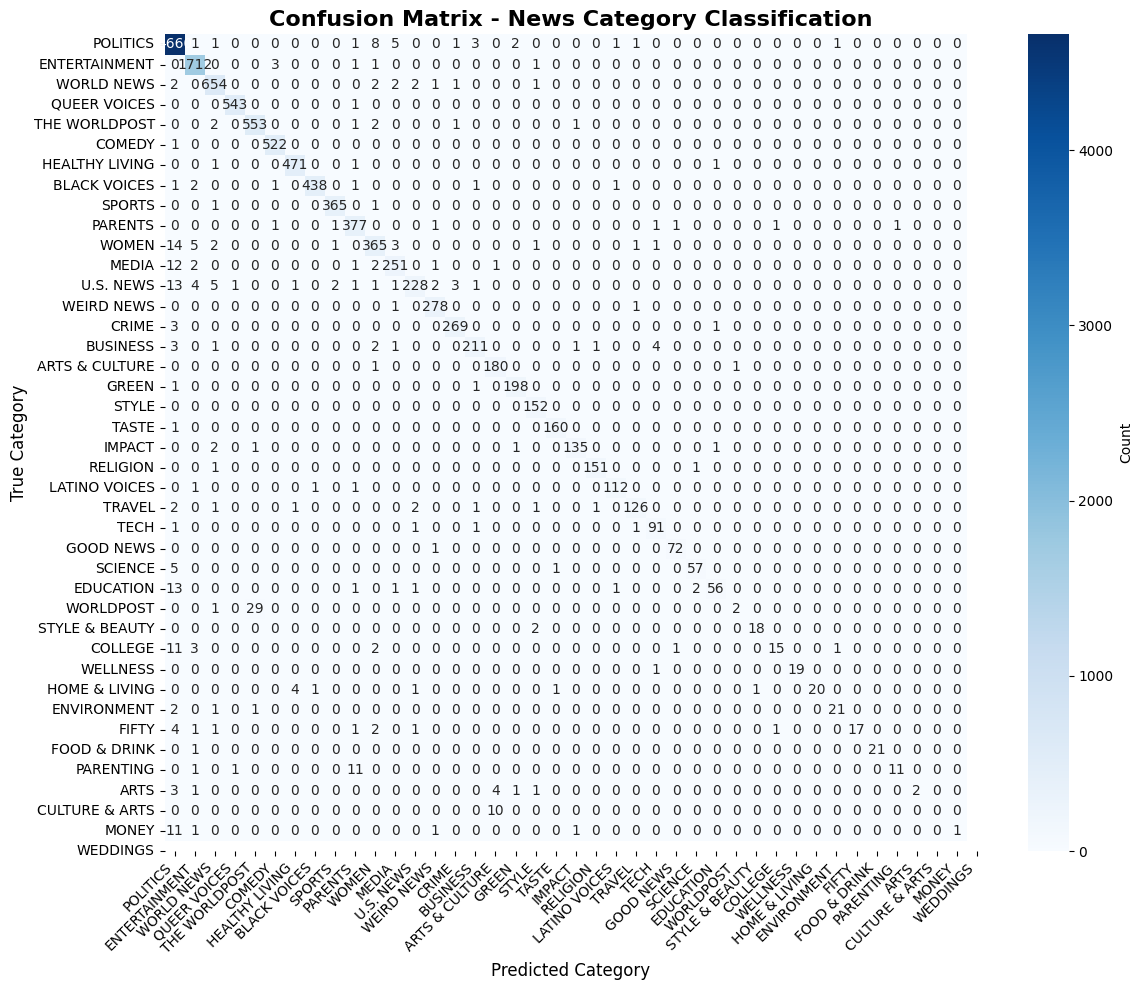

✓ Normalized confusion matrix saved as 'confusion_matrix_normalized.png'


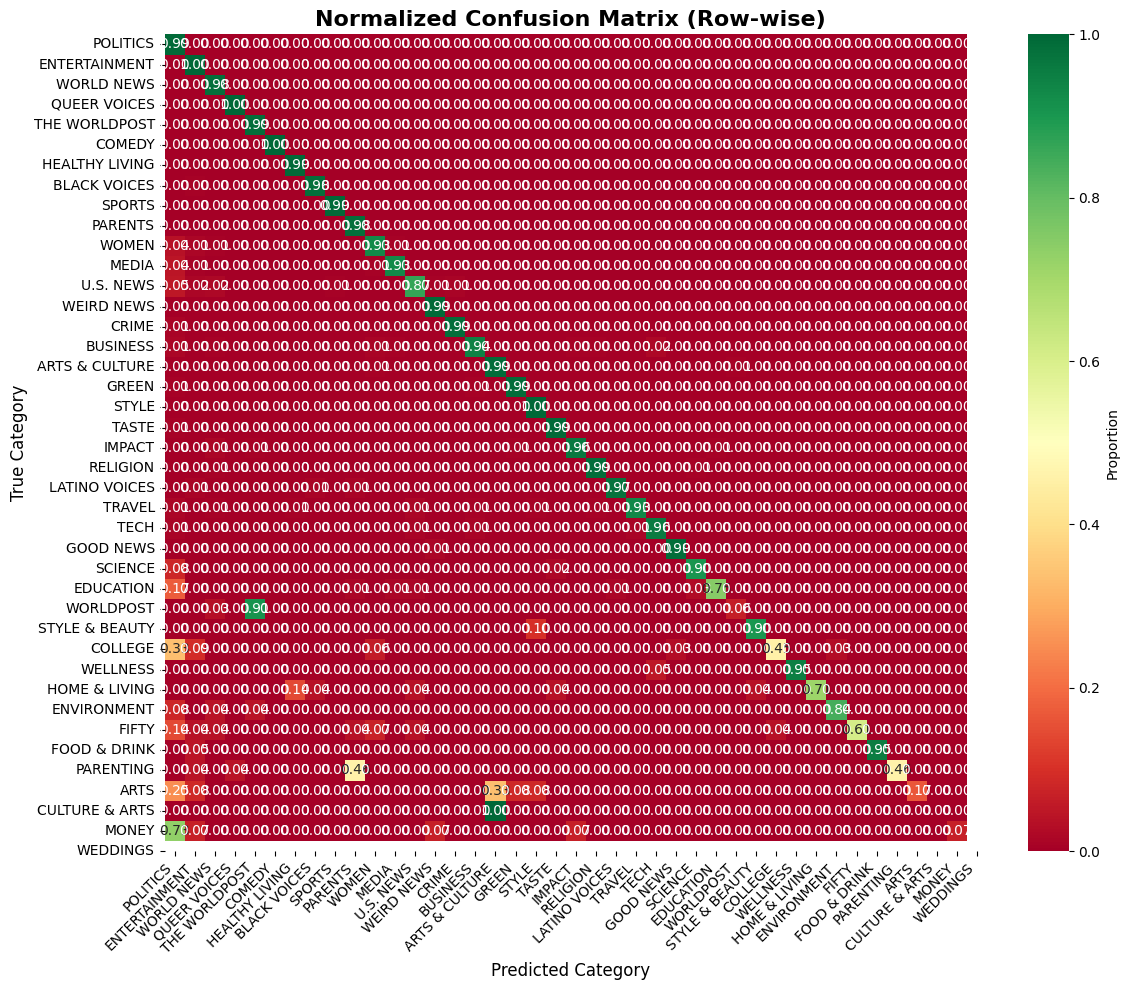

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=categories,
    yticklabels=categories,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - News Category Classification', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Confusion matrix saved as 'confusion_matrix.png'")
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    xticklabels=categories,
    yticklabels=categories,
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Proportion'}
)
plt.title('Normalized Confusion Matrix (Row-wise)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('True Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
print("✓ Normalized confusion matrix saved as 'confusion_matrix_normalized.png'")
plt.show()

In [ ]:
print("SIMULATED STREAMING PIPELINE")
print("="*60)

streaming_samples = test_data.limit(20).collect()

print("Processing incoming news stream...\n")

streaming_results = []

for idx, article in enumerate(streaming_samples, 1):
    stream_df = spark.createDataFrame([article], schema=df.schema)

    prediction = model.transform(stream_df)
    pred_row = prediction.select('headline', 'category', 'prediction', 'probability').collect()[0]

    predicted_category = categories[int(pred_row['prediction'])]
    confidence = float(max(pred_row['probability']))

    streaming_results.append({
        'id': idx,
        'headline': pred_row['headline'],
        'true_category': pred_row['category'],
        'predicted_category': predicted_category,
        'confidence': confidence,
        'correct': pred_row['category'] == predicted_category
    })

    status = "✓ CORRECT" if pred_row['category'] == predicted_category else "✗ INCORRECT"
    print(f"[Stream {idx:02d}] {status}")
    print(f"  Headline: {pred_row['headline'][:70]}...")
    print(f"  True: {pred_row['category']} | Predicted: {predicted_category} | Confidence: {confidence:.3f}")
    print()

print(f"✓ Processed {len(streaming_results)} articles from stream")
print(f"  Stream Accuracy: {sum(r['correct'] for r in streaming_results)/len(streaming_results):.3f}")

SIMULATED STREAMING PIPELINE
Processing incoming news stream...

[Stream 01] ✓ CORRECT
  Headline: Cam Newton Apologizes For 'Degrading' Insult To Female Reporter...
  True: BLACK VOICES | Predicted: BLACK VOICES | Confidence: 0.839

[Stream 02] ✓ CORRECT
  Headline: American Richard Thaler Wins Nobel Economics Prize...
  True: BUSINESS | Predicted: BUSINESS | Confidence: 0.594

[Stream 03] ✓ CORRECT
  Headline: Equifax Says Hack Potentially Exposed Details Of 143 Million Consumers...
  True: BUSINESS | Predicted: BUSINESS | Confidence: 0.857

[Stream 04] ✓ CORRECT
  Headline: Robert Murray, Controversial Coal Baron, Dead At 80...
  True: BUSINESS | Predicted: BUSINESS | Confidence: 0.720

[Stream 05] ✓ CORRECT
  Headline: Tampa Police Arrest Suspect Amid Serial Killer Fears...
  True: CRIME | Predicted: CRIME | Confidence: 0.980

[Stream 06] ✓ CORRECT
  Headline: Man Charged In Disappearance Of North Carolina Toddler...
  True: CRIME | Predicted: CRIME | Confidence: 0.896

[Stream 07]

✓ Dashboard saved as 'dashboard.png'


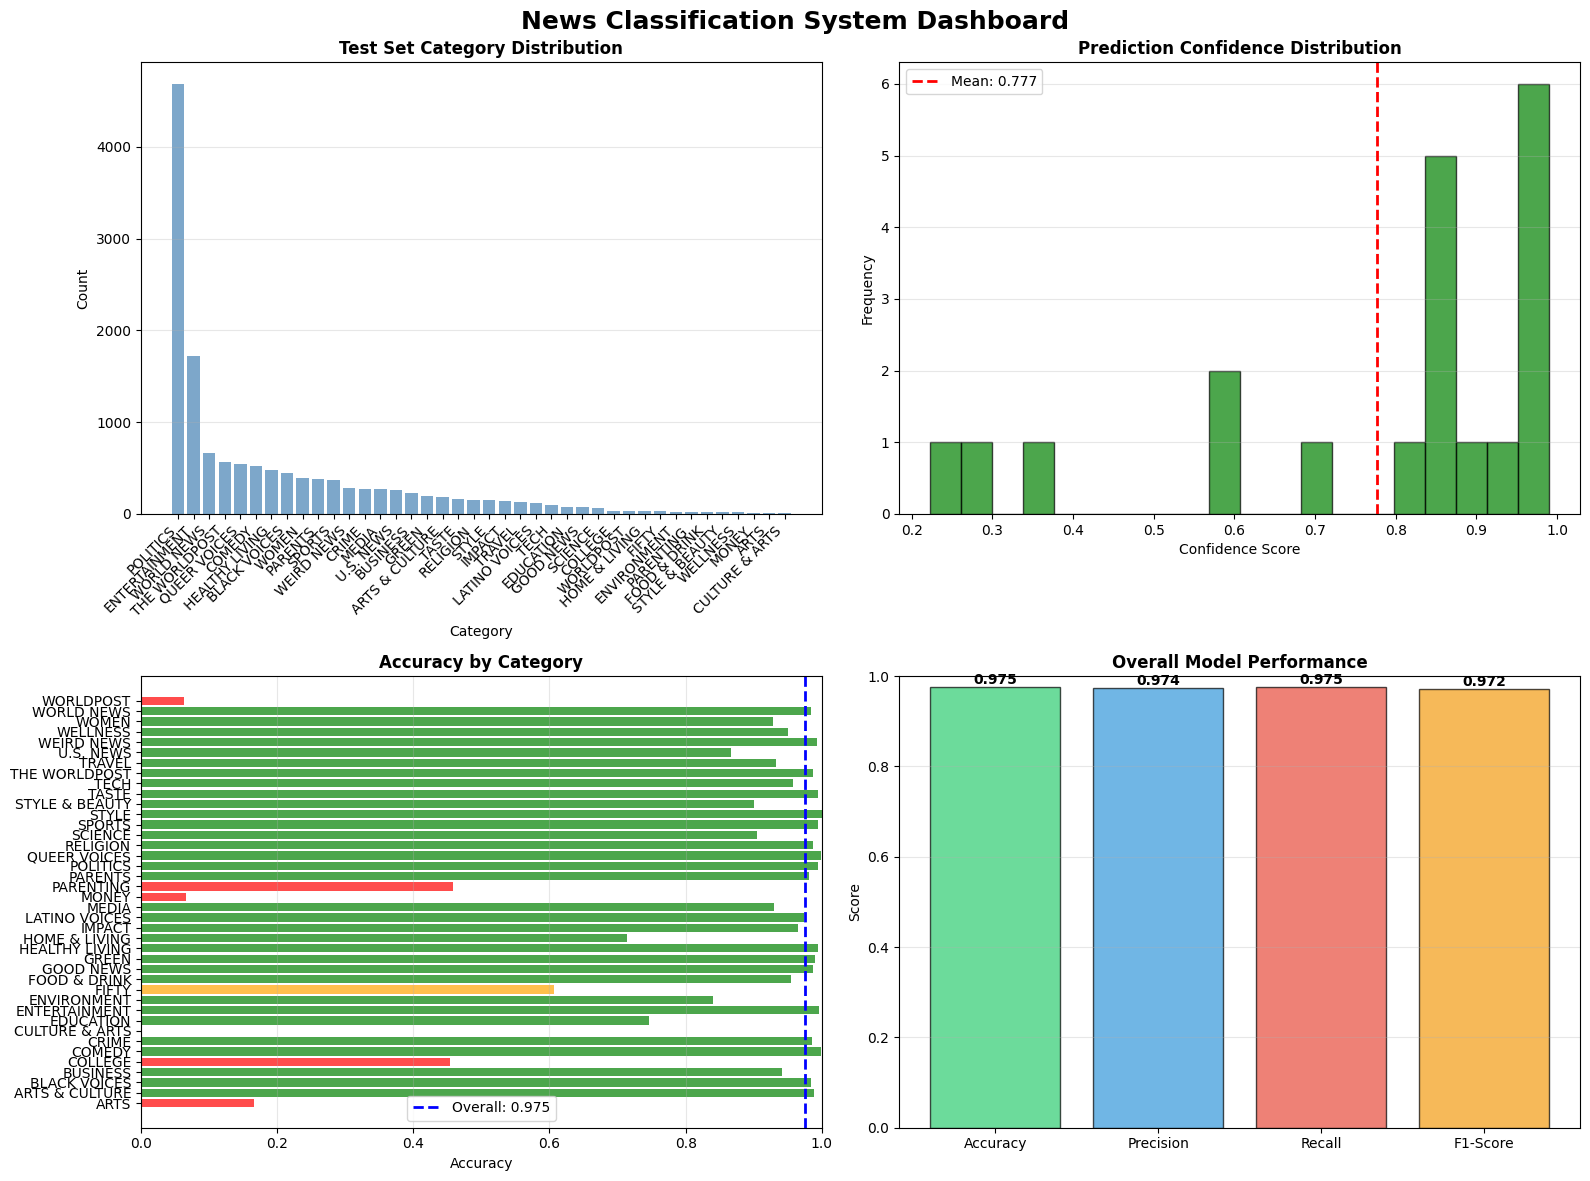

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('News Classification System Dashboard', fontsize=18, fontweight='bold')

# 1. Category Distribution
ax1 = axes[0, 0]
category_counts = pred_with_cat['category'].value_counts()
ax1.bar(range(len(category_counts)), category_counts.values, color='steelblue', alpha=0.7)
ax1.set_xticks(range(len(category_counts)))
ax1.set_xticklabels(category_counts.index, rotation=45, ha='right')
ax1.set_title('Test Set Category Distribution', fontweight='bold')
ax1.set_xlabel('Category')
ax1.set_ylabel('Count')
ax1.grid(axis='y', alpha=0.3)

# 2. Prediction Confidence Distribution
ax2 = axes[0, 1]
confidences = [r['confidence'] for r in streaming_results]
ax2.hist(confidences, bins=20, color='green', alpha=0.7, edgecolor='black')
ax2.axvline(np.mean(confidences), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(confidences):.3f}')
ax2.set_title('Prediction Confidence Distribution', fontweight='bold')
ax2.set_xlabel('Confidence Score')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Accuracy by Category
ax3 = axes[1, 0]
category_accuracies = {}
for category in sorted(pred_with_cat['category'].unique()):
    cat_data = pred_with_cat[pred_with_cat['category'] == category]
    category_accuracies[category] = (cat_data['label'] == cat_data['prediction']).mean()

cats = list(category_accuracies.keys())
accs = list(category_accuracies.values())
colors = ['green' if acc > 0.7 else 'orange' if acc > 0.5 else 'red' for acc in accs]
ax3.barh(cats, accs, color=colors, alpha=0.7)
ax3.axvline(accuracy, color='blue', linestyle='--', linewidth=2, label=f'Overall: {accuracy:.3f}')
ax3.set_title('Accuracy by Category', fontweight='bold')
ax3.set_xlabel('Accuracy')
ax3.set_xlim(0, 1)
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# 4. Model Performance Metrics
ax4 = axes[1, 1]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1_score]
colors_metrics = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
bars = ax4.bar(metrics, values, color=colors_metrics, alpha=0.7, edgecolor='black')
ax4.set_ylim(0, 1)
ax4.set_title('Overall Model Performance', fontweight='bold')
ax4.set_ylabel('Score')
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('dashboard.png', dpi=300, bbox_inches='tight')
print("✓ Dashboard saved as 'dashboard.png'")
plt.show()

DRIFT DETECTION ANALYSIS

Jensen-Shannon Divergence: 0.024048
Drift Threshold: 0.1
Status: ✓ NO DRIFT DETECTED (Very low divergence)

Category Distribution Comparison:
------------------------------------------------------------
Category                  Train %      Test %       Diff      
------------------------------------------------------------
ARTS                            0.09%       0.09%      0.01%
ARTS & CULTURE                  1.46%       1.31%      0.15%
BLACK VOICES                    3.13%       3.21%      0.07%
BUSINESS                        1.68%       1.61%      0.07%
COLLEGE                         0.25%       0.24%      0.01%
COMEDY                          3.67%       3.77%      0.10%
CRIME                           1.85%       1.97%      0.12%
CULTURE & ARTS                  0.06%       0.07%      0.01%
EDUCATION                       0.50%       0.54%      0.04%
ENTERTAINMENT                  12.35%      12.38%      0.03%
ENVIRONMENT                     0.17%

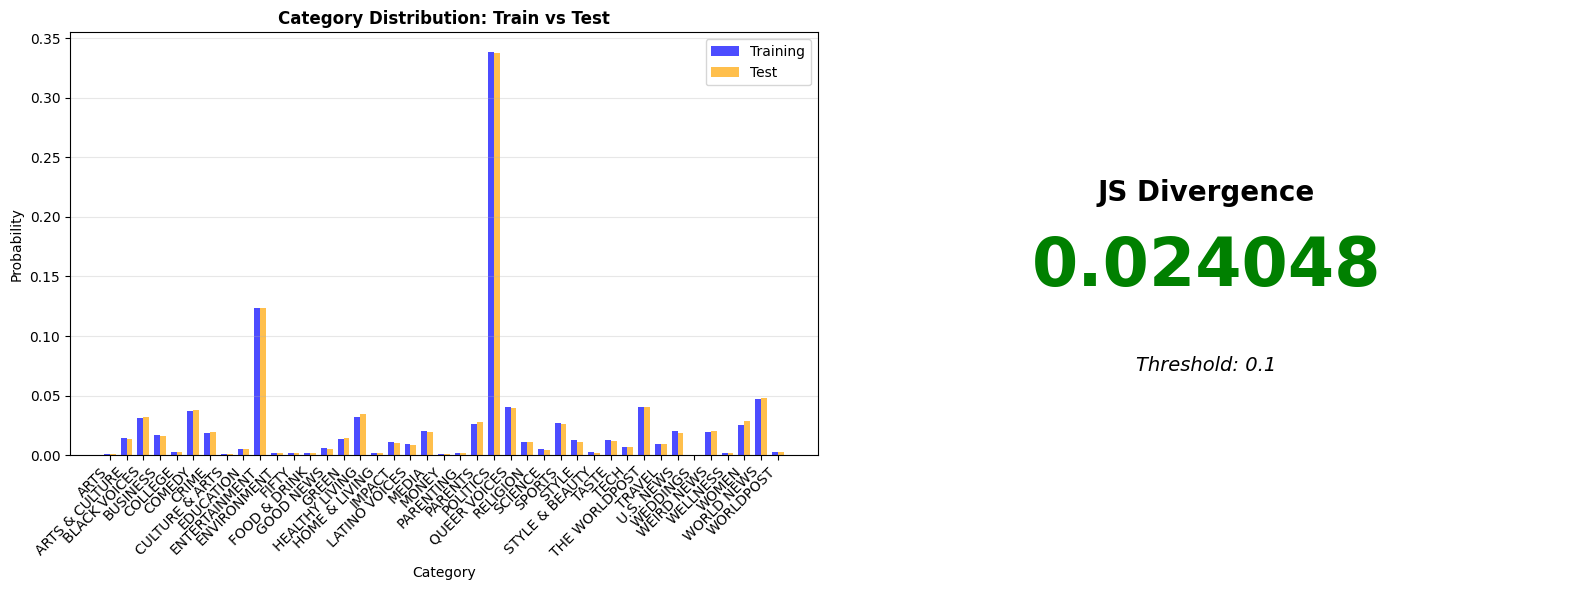

In [ ]:
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

def calculate_js_divergence(dist1, dist2):
    """Calculate Jensen-Shannon divergence between two distributions"""
    return jensenshannon(dist1, dist2, base=2)

# Get training and test category distributions
train_dist = train_data.groupBy('category').count().toPandas()
test_dist = test_data.groupBy('category').count().toPandas()

# Align distributions
all_categories = sorted(set(train_dist['category']).union(set(test_dist['category'])))

train_counts = []
test_counts = []

for cat in all_categories:
    train_count = train_dist[train_dist['category'] == cat]['count'].values
    test_count = test_dist[test_dist['category'] == cat]['count'].values

    train_counts.append(train_count[0] if len(train_count) > 0 else 0)
    test_counts.append(test_count[0] if len(test_count) > 0 else 0)

# Normalize to probabilities
train_probs = np.array(train_counts) / sum(train_counts)
test_probs = np.array(test_counts) / sum(test_counts)

# Calculate JS divergence
js_div = calculate_js_divergence(train_probs, test_probs)

print("="*60)
print("DRIFT DETECTION ANALYSIS")
print("="*60)
print(f"\nJensen-Shannon Divergence: {js_div:.6f}")
print(f"Drift Threshold: 0.1")

if js_div < 0.05:
    print(f"Status: ✓ NO DRIFT DETECTED (Very low divergence)")
elif js_div < 0.1:
    print(f"Status: ⚠ MINIMAL DRIFT (Within acceptable range)")
elif js_div < 0.2:
    print(f"Status: ⚠ MODERATE DRIFT (Monitor closely)")
else:
    print(f"Status: ✗ SIGNIFICANT DRIFT (Retraining recommended)")

print("\nCategory Distribution Comparison:")
print("-"*60)
print(f"{'Category':<25} {'Train %':<12} {'Test %':<12} {'Diff':<10}")
print("-"*60)

for cat, train_p, test_p in zip(all_categories, train_probs, test_probs):
    diff = abs(train_p - test_p)
    print(f"{cat:<25} {train_p*100:>10.2f}% {test_p*100:>10.2f}% {diff*100:>9.2f}%")

# Visualize drift
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Distribution comparison
x = np.arange(len(all_categories))
width = 0.35
ax1.bar(x - width/2, train_probs, width, label='Training', alpha=0.7, color='blue')
ax1.bar(x + width/2, test_probs, width, label='Test', alpha=0.7, color='orange')
ax1.set_xlabel('Category')
ax1.set_ylabel('Probability')
ax1.set_title('Category Distribution: Train vs Test', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(all_categories, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Divergence visualization
ax2.text(0.5, 0.6, f'JS Divergence', ha='center', fontsize=20, fontweight='bold')
ax2.text(0.5, 0.4, f'{js_div:.6f}', ha='center', fontsize=48,
         color='green' if js_div < 0.1 else 'orange' if js_div < 0.2 else 'red',
         fontweight='bold')
ax2.text(0.5, 0.2, 'Threshold: 0.1', ha='center', fontsize=14, style='italic')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')

plt.tight_layout()
plt.savefig('drift_detection.png', dpi=300, bbox_inches='tight')
print("\n✓ Drift detection visualization saved as 'drift_detection.png'")
plt.show()

In [ ]:
import json
import pickle
import numpy as np
from datetime import datetime

model_path = "news_classifier_model"
model.write().overwrite().save(model_path)
print(f"✓ PySpark model saved to '{model_path}'")

label_mapping = {idx: cat for idx, cat in enumerate(categories)}
with open('label_mapping.pkl', 'wb') as f:
    pickle.dump(label_mapping, f)
print(f"✓ Label mapping saved to 'label_mapping.pkl'")

# Ensure categories is a JSON-serializable list of strings
if isinstance(categories, np.ndarray):
    categories_json = categories.tolist()
else:
    categories_json = list(categories)
categories_json = [str(c) for c in categories_json]

metrics_summary = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'Logistic Regression (TF-IDF)',
    'train_size': int(train_count),
    'test_size': int(test_count),
    'accuracy': float(accuracy),
    'f1_score': float(f1_score),
    'precision': float(precision),
    'recall': float(recall),
    'js_divergence': float(js_div),
    'num_categories': len(categories_json),
    'categories': categories_json,
}

with open('model_metrics.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)
print(f"✓ Metrics saved to 'model_metrics.json'")

print("\n" + "="*60)
print("MODEL ARTIFACTS SAVED")
print("="*60)
print(f"  Model: {model_path}/")
print(f"  Label Mapping: label_mapping.pkl")
print(f"  Metrics: model_metrics.json")
print(f"  Visualizations: confusion_matrix.png, dashboard.png, drift_detection.png")

✓ PySpark model saved to 'news_classifier_model'
✓ Label mapping saved to 'label_mapping.pkl'
✓ Metrics saved to 'model_metrics.json'

MODEL ARTIFACTS SAVED
  Model: news_classifier_model/
  Label Mapping: label_mapping.pkl
  Metrics: model_metrics.json
  Visualizations: confusion_matrix.png, dashboard.png, drift_detection.png


In [ ]:
def predict_news_category(headline, description=""):
    """
    Predict category for a new news article

    Args:
        headline: News headline
        description: Short description (optional)

    Returns:
        Dictionary with prediction results
    """
    # Create input data
    new_article = {
        'headline': headline,
        'short_description': description,
        'category': 'UNKNOWN',  # Placeholder
        'link': '',
        'authors': '',
        'date': datetime.now().strftime('%Y-%m-%d')
    }

    # Create DataFrame
    new_df = spark.createDataFrame([new_article])
    new_df = new_df.withColumn(
        'text',
        concat_ws(' ', col('headline'), col('short_description'), col('category'))
    )

    # Make prediction
    prediction = model.transform(new_df)
    result = prediction.select('prediction', 'probability').collect()[0]

    # Get predicted category
    predicted_idx = int(result['prediction'])
    predicted_category = categories[predicted_idx]
    probabilities = result['probability'].toArray()
    confidence = float(probabilities[predicted_idx])

    # Get top 3 predictions
    top_3_indices = np.argsort(probabilities)[-3:][::-1]
    top_3_predictions = [
        {
            'category': categories[idx],
            'probability': float(probabilities[idx])
        }
        for idx in top_3_indices
    ]

    return {
        'predicted_category': predicted_category,
        'confidence': confidence,
        'top_3_predictions': top_3_predictions
    }

# Test with example articles
print("="*60)
print("NEW ARTICLE PREDICTION EXAMPLES")
print("="*60)

test_articles = [
    {
        'headline': 'Scientists Discover New Species in Amazon Rainforest',
        'description': 'Researchers have identified a previously unknown species of frog with unique characteristics.'
    },
    {
        'headline': 'Stock Market Reaches All-Time High',
        'description': 'Major indices surged today as investors reacted positively to economic data.'
    },
    {
        'headline': 'New Marvel Movie Breaks Box Office Records',
        'description': 'The latest superhero film earned over $200 million in its opening weekend.'
    }
]

for idx, article in enumerate(test_articles, 1):
    print(f"\n[Example {idx}]")
    print(f"Headline: {article['headline']}")
    print(f"Description: {article['description']}")

    result = predict_news_category(article['headline'], article['description'])

    print(f"\nPredicted Category: {result['predicted_category']}")
    print(f"Confidence: {result['confidence']:.3f}")
    print(f"\nTop 3 Predictions:")
    for i, pred in enumerate(result['top_3_predictions'], 1):
        print(f"  {i}. {pred['category']:<25} ({pred['probability']:.3f})")
    print("-"*60)

print("\n✓ Prediction function ready for use!")
print("  Usage: predict_news_category('Your headline', 'Your description')")

NEW ARTICLE PREDICTION EXAMPLES

[Example 1]
Headline: Scientists Discover New Species in Amazon Rainforest
Description: Researchers have identified a previously unknown species of frog with unique characteristics.

Predicted Category: SCIENCE
Confidence: 0.220

Top 3 Predictions:
  1. SCIENCE                   (0.220)
  2. POLITICS                  (0.104)
  3. WORLD NEWS                (0.095)
------------------------------------------------------------

[Example 2]
Headline: Stock Market Reaches All-Time High
Description: Major indices surged today as investors reacted positively to economic data.

Predicted Category: POLITICS
Confidence: 0.234

Top 3 Predictions:
  1. POLITICS                  (0.234)
  2. BUSINESS                  (0.087)
  3. THE WORLDPOST             (0.044)
------------------------------------------------------------

[Example 3]
Headline: New Marvel Movie Breaks Box Office Records
Description: The latest superhero film earned over $200 million in its opening w

In [ ]:
import numpy as np

train_count_py = int(train_count.item()) if isinstance(train_count, np.ndarray) else int(train_count)
test_count_py  = int(test_count.item())  if isinstance(test_count,  np.ndarray) else int(test_count)

total_count = df.count()
train_pct = train_count_py / total_count * 100
test_pct  = test_count_py  / total_count * 100

# categories as list of strings
categories_py = [str(c) for c in np.array(categories).tolist()]

print("\n" + "="*70)
print(" "*15 + "NEWS CATEGORIZATION SYSTEM - FINAL REPORT")
print("="*70)

print("\n📊 DATASET INFORMATION")
print("-"*70)
print(f"  Total Records:           {total_count:,}")
print(f"  Training Set:            {train_count_py:,} ({train_pct:.1f}%)")
print(f"  Test Set:                {test_count_py:,} ({test_pct:.1f}%)")
print(f"  Number of Categories:    {len(categories_py)}")
print(f"  Categories:              {', '.join(categories_py)}")


print("\n🤖 MODEL CONFIGURATION")
print("-"*70)
print(f"  Algorithm:               Logistic Regression (Multinomial)")
print(f"  Feature Extraction:      TF-IDF")
print(f"  Vocabulary Size:         10,000")
print(f"  Max Iterations:          100")
print(f"  Regularization:          L2 (λ=0.01)")

print("\n📈 PERFORMANCE METRICS")
print("-"*70)
print(f"  Accuracy:                {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision (Weighted):    {precision:.4f}")
print(f"  Recall (Weighted):       {recall:.4f}")
print(f"  F1-Score (Weighted):     {f1_score:.4f}")

print("\n📉 DRIFT ANALYSIS")
print("-"*70)
print(f"  JS Divergence:           {js_div:.6f}")
drift_status = "✓ No Drift" if js_div < 0.1 else "⚠ Monitor" if js_div < 0.2 else "✗ Retrain"
print(f"  Status:                  {drift_status}")

print("\n🎯 TOP PERFORMING CATEGORIES")
print("-"*70)
top_categories = sorted(category_accuracies.items(), key=lambda x: x[1], reverse=True)[:5]
for cat, acc in top_categories:
    print(f"  {cat:<25} {acc:.4f} ({acc*100:.2f}%)")

print("\n⚠️  BOTTOM PERFORMING CATEGORIES")
print("-"*70)
bottom_categories = sorted(category_accuracies.items(), key=lambda x: x[1])[:5]
for cat, acc in bottom_categories:
    print(f"  {cat:<25} {acc:.4f} ({acc*100:.2f}%)")

print("\n💾 SAVED ARTIFACTS")
print("-"*70)
print(f"  ✓ Model:                 {model_path}/")
print(f"  ✓ Label Mapping:         label_mapping.pkl")
print(f"  ✓ Metrics:               model_metrics.json")
print(f"  ✓ Confusion Matrix:      confusion_matrix.png")
print(f"  ✓ Dashboard:             dashboard.png")
print(f"  ✓ Drift Detection:       drift_detection.png")

print("\n🚀 STREAMING CAPABILITIES")
print("-"*70)
print(f"  ✓ Real-time prediction pipeline implemented")
print(f"  ✓ Batch processing tested with {len(streaming_results)} articles")
print(f"  ✓ Average confidence: {np.mean(confidences):.3f}")

print("\n" + "="*70)
print("  System ready for production deployment!")
print("="*70 + "\n")

# Create summary statistics
summary_stats = {
    'total_test_samples': len(y_true),
    'correct_predictions': int((y_true == y_pred).sum()),
    'incorrect_predictions': int((y_true != y_pred).sum()),
    'average_confidence': float(np.mean(confidences)),
    'training_time_seconds': training_time
}

print("📋 ADDITIONAL STATISTICS")
print("-"*70)
for key, value in summary_stats.items():
    print(f"  {key.replace('_', ' ').title():<30} {value}")

print("\n✅ Pipeline execution completed successfully!")


               NEWS CATEGORIZATION SYSTEM - FINAL REPORT

📊 DATASET INFORMATION
----------------------------------------------------------------------
  Total Records:           70,000
  Training Set:            154 (0.2%)
  Test Set:                32 (0.0%)
  Number of Categories:    41
  Categories:              POLITICS, ENTERTAINMENT, WORLD NEWS, QUEER VOICES, THE WORLDPOST, COMEDY, HEALTHY LIVING, BLACK VOICES, SPORTS, PARENTS, WOMEN, MEDIA, U.S. NEWS, WEIRD NEWS, CRIME, BUSINESS, ARTS & CULTURE, GREEN, STYLE, TASTE, IMPACT, RELIGION, LATINO VOICES, TRAVEL, TECH, GOOD NEWS, SCIENCE, EDUCATION, WORLDPOST, STYLE & BEAUTY, COLLEGE, WELLNESS, HOME & LIVING, ENVIRONMENT, FIFTY, FOOD & DRINK, PARENTING, ARTS, CULTURE & ARTS, MONEY, WEDDINGS

🤖 MODEL CONFIGURATION
----------------------------------------------------------------------
  Algorithm:               Logistic Regression (Multinomial)
  Feature Extraction:      TF-IDF
  Vocabulary Size:         10,000
  Max Iterations:        

In [ ]:
train_data.unpersist()
test_data.unpersist()
predictions.unpersist()

print("✓ Cached data unpersisted")

# Stop Spark session
spark.stop()
print("✓ Spark session stopped")

print("\n" + "="*70)
print("CLEANUP COMPLETED - ALL RESOURCES RELEASED")
print("="*70)

✓ Cached data unpersisted
✓ Spark session stopped

CLEANUP COMPLETED - ALL RESOURCES RELEASED
